<a href="https://colab.research.google.com/github/m96mukesh/handwritten_medical_prescriptions./blob/main/medicine_prescription.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install langchain_openai


  Using cached langchain_openai-0.3.14-py3-none-any.whl.metadata (2.3 kB)
Using cached langchain_openai-0.3.14-py3-none-any.whl (62 kB)


In [2]:
pip install -qU "langchain[google-genai]"

In [3]:
from typing import Any
import os
import glob
import json
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import base64
from IPython.display import Image, display, HTML
import pandas as pd
from google.colab import userdata
from langchain_core.pydantic_v1 import BaseModel, Field
#from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.exceptions import OutputParserException
from langchain_core.runnables import chain
from pydantic import BaseModel

/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py:3553: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
import getpass
import os

if not os.environ.get("GOOGLE_API_KEY"):
  os.environ["GOOGLE_API_KEY"] = getpass.getpass("Enter API key for Google Gemini: ")

from langchain.chat_models import init_chat_model

model = init_chat_model("gemini-2.0-flash", model_provider="google_genai")

Enter API key for Google Gemini: ··········


In [5]:
import glob
# Get the Scanned handwritten medical prescriptions images:
!wget -q "/content/drive/MyDrive/Medical data image/archive (1)/data" -O archive.zip


# Get images paths:
img_path = "/content/data/1.jpeg"
img_dir = "/content/data"

# Collect image paths from the directory:
image_paths = glob.glob(os.path.join(img_dir, "*.jpg"))

In [6]:
import os
import glob

# Step 1: Set the folder where images are stored
img_dir = "/content/drive/MyDrive/Medical data image/archive (1)/data"

# Step 2: Set a sample image path (if you want)
img_path = os.path.join(img_dir, "1.jpeg")

# Step 3: Collect all image paths
image_paths = glob.glob(os.path.join(img_dir, "*.jpg"))
image_paths += glob.glob(os.path.join(img_dir, "*.jpeg"))  # also collect .jpeg

# Step 4: Print how many images were found
print(f"Total images found: {len(image_paths)}")
print(image_paths[:5])  # Show the first 5 image paths


Total images found: 139
['/content/drive/MyDrive/Medical data image/archive (1)/data/107.jpg', '/content/drive/MyDrive/Medical data image/archive (1)/data/106.jpg', '/content/drive/MyDrive/Medical data image/archive (1)/data/105.jpg', '/content/drive/MyDrive/Medical data image/archive (1)/data/103.jpg', '/content/drive/MyDrive/Medical data image/archive (1)/data/101.jpg']


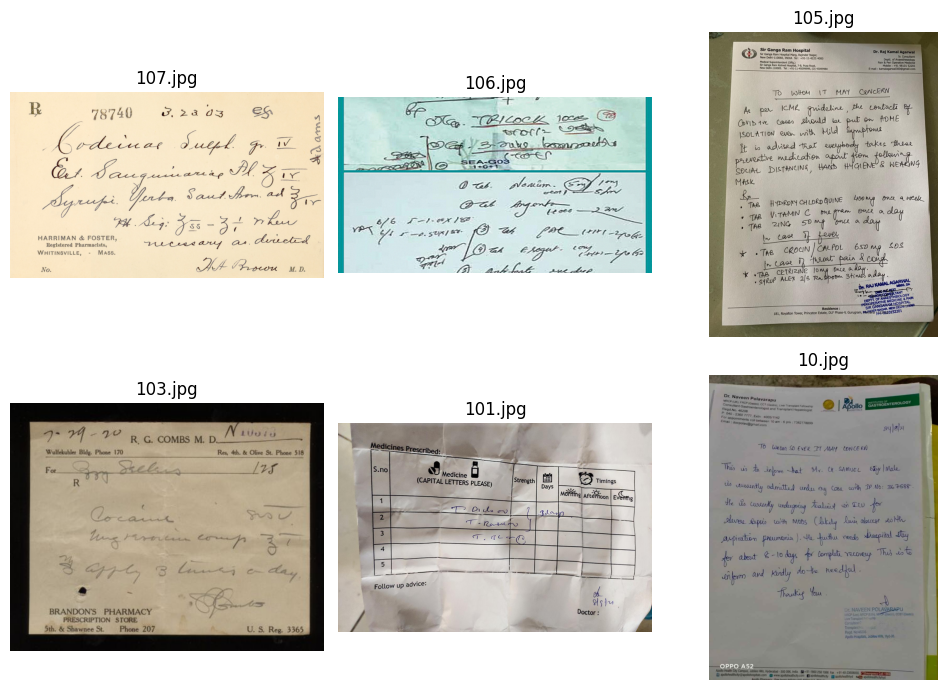

In [8]:
def display_image_grid(image_paths, rows=2, cols=3, figsize=(10, 7)):
    """
    Display images in a grid layout
    """
    fig = plt.figure(figsize=figsize)
    max_images = rows * cols
    image_paths = image_paths[:max_images]

    for idx, path in enumerate(image_paths):
        ax = fig.add_subplot(rows, cols, idx + 1)
        img = mpimg.imread(path)
        ax.imshow(img)
        ax.axis('off')
        filename = path.split('/')[-1]
        ax.set_title(filename)

    plt.tight_layout()
    plt.show()

display_image_grid(image_paths)

In [9]:
def image_encoding(inputs):
    """Load and convert image to base64 encoding"""

    with open(inputs["image_path"], "rb") as image_file:
        image_base64 = base64.b64encode(image_file.read()).decode("utf-8")
    return {"image": image_base64}

In [10]:
class medicine(BaseModel):

    doctor: str = Field(
        ...,
        examples=["Dr. salim", "Dr. Amit", "Dr. Mukesh", 'Dr. sanjeev S', 'Dr. ramesh kumar'],
        description="what is the doctor name.",
    )

    Age: str = Field(
        ...,
        examples= ["45","45y","45 years"],
        description="Age of the perients in years",
    )

    Gender: str = Field(
        ...,
        examples=["Male", "M", "F", ""],
        description="Gender of patients.",
    )

    Medicine: str = Field(
        ...,
        examples=["Amoxicillin", "Ibuprofen", "PCM","Metformin"],
        description="Medicine prescribed.",
    )

    Dose: str = Field(
        ...,
        example=["850 mg", "200 mg", "500 mg", "100 mg"],
        description="Medicine dosages.",
    )

    Duration: str = Field(
        ...,
        example=["7 days", "7 d", "10 day", "10d"],
        description="Medicine duration.",
    )

In [11]:
parser = JsonOutputParser(pydantic_object = medicine)
instructions = parser.get_format_instructions()
instructions

/usr/local/lib/python3.11/dist-packages/pydantic/json_schema.py:2279: PydanticJsonSchemaWarning: Default value default=Ellipsis description='what is the doctor name.' extra={'examples': ['Dr. salim', 'Dr. Amit', 'Dr. Mukesh', 'Dr. sanjeev S', 'Dr. ramesh kumar']} is not JSON serializable; excluding default from JSON schema [non-serializable-default]
  warnings.warn(message, PydanticJsonSchemaWarning)
/usr/local/lib/python3.11/dist-packages/pydantic/json_schema.py:2279: PydanticJsonSchemaWarning: Default value default=Ellipsis description='Age of the perients in years' extra={'examples': ['45', '45y', '45 years']} is not JSON serializable; excluding default from JSON schema [non-serializable-default]
  warnings.warn(message, PydanticJsonSchemaWarning)
/usr/local/lib/python3.11/dist-packages/pydantic/json_schema.py:2279: PydanticJsonSchemaWarning: Default value default=Ellipsis description='Gender of patients.' extra={'examples': ['Male', 'M', 'F', '']} is not JSON serializable; excludin

'The output should be formatted as a JSON instance that conforms to the JSON schema below.\n\nAs an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}\nthe object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.\n\nHere is the output schema:\n```\n{"properties": {"doctor": {"title": "Doctor", "type": "string"}, "Age": {"title": "Age", "type": "string"}, "Gender": {"title": "Gender", "type": "string"}, "Medicine": {"title": "Medicine", "type": "string"}, "Dose": {"title": "Dose", "type": "string"}, "Duration": {"title": "Duration", "type": "string"}}}\n```'

In [12]:
@chain
def prompt (inputs):
    """Create the prompt"""

    prompt = [
    SystemMessage(content="""You are an AI assistant whose job is to inspect an image and provide the desired information from the image. If the desired field is not clear or not well detected, return None for this field. Do not try to guess."""),
    HumanMessage(
        content=[
            {"type": "text", "text": """Examine the main vehicle type, license plate number, make, model and color."""},
            {"type": "text", "text": instructions},
            {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{inputs['image']}", "detail": "low", }}]
        )
    ]
    return prompt

In [13]:
@chain
def MLLM_response(inputs):
    """Invoke GPT model to extract information from the image"""

    model: model = init_chat_model("gemini-2.0-flash", model_provider="google_genai")
    output = model.invoke(inputs)
    return output.content

In [14]:
pipeline = image_encoding | prompt | MLLM_response | parser

In [16]:
img_path = os.path.join(img_dir, "1.jpg")

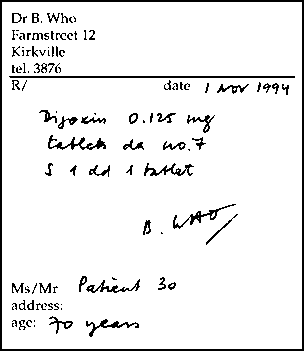

In [17]:
display(Image(img_path))

In [18]:
output = pipeline.invoke({"image_path": f"{img_path}"})
output

{'doctor': 'Dr B. Who',
 'Age': '70 years',
 'Gender': None,
 'Medicine': 'Digoxin',
 'Dose': '0.125 mg',
 'Duration': None}

In [19]:
json_output = json.dumps(output)

In [22]:
import random
# Step 2: Randomly select 10 images (or the first 10 if you want)
selected_image_paths = random.sample(image_paths, 10) if len(image_paths) >= 10 else image_paths

In [23]:
# Step 3: Prepare batch input
batch_input = [{"image_path": path} for path in selected_image_paths]

# Step 4: Run pipeline batch inference
output = pipeline.batch(batch_input)

In [25]:
df = pd.DataFrame(output)
files_list = ([os.path.basename(path) for path in selected_image_paths])
df.index = files_list
df

,doctor,Age,Gender,Medicine,Dose,Duration
93.jpg,None,None,None,Ao,"0,04",None
92.jpg,Dr.M VENKATESWARA RAO,None,None,Amphotericin B,300 mg,2 wks
81.jpg,Ramesh S.,2,None,Megacutorre,4ml,5 d
43.jpg,G.F.L,None,None,Liq. Strych,87 120,None
64.jpg,None,None,None,None,None,None
22.jpg,WILLIAM LEWIS TOWNS,None,None,Belladonna,None,None
48.jpg,None,None,None,Pause,None,None
107.jpg,HA Brocon,None,None,Codeinas Sueph,gr. TⅣ,when necessary
18 (1).jpg,Allen,None,None,Phenytoin Sodium Extended,100 mg tid,#90
6.jpg,Dr. Abhishek,55,M,Romdesivir,100 mg IV OD,4 days


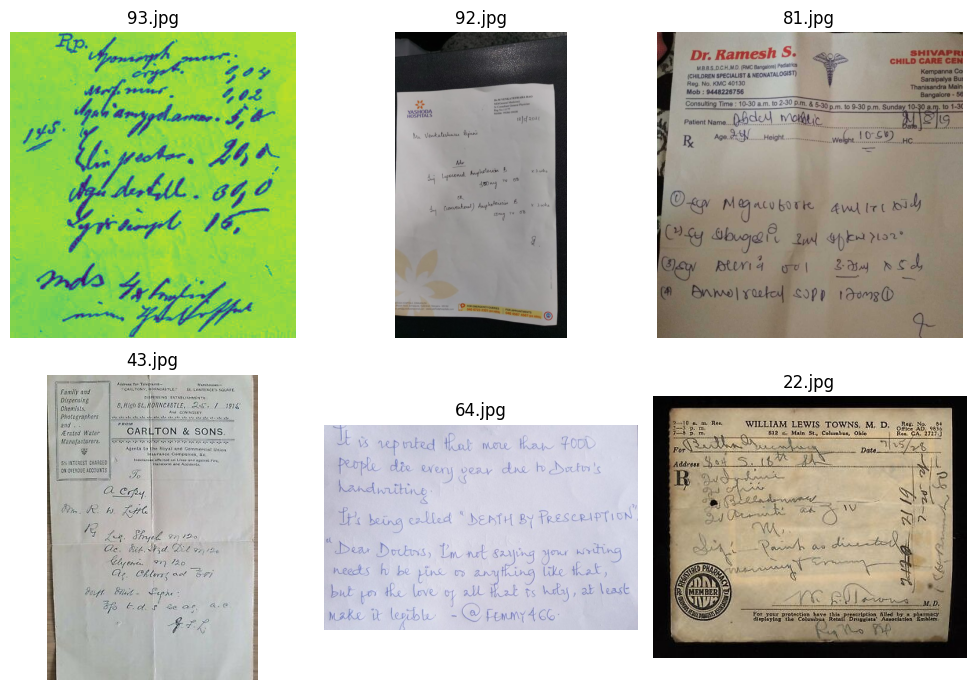

In [26]:
display_image_grid(selected_image_paths)